# ROC曲線を書く

## はじめに
理解の整理のためにROC曲線についてまとめます。今やエクセルでもポチッとすれば自動で描いてくれますが、実際どんな手順で書かれるのか追っていくことにします。~~ネットで調べると勘違いして書いている記事がgoogle上位にヒットして驚きました。(TPRを (そこまでカウントしたTP)/(全体のTP)としてたり、Thresholdの概念がなかったり…)~~

## 後で目次

## 前提知識

まず確率分布からROC曲線のアイデアを理解することが必要となります。こちらの記事が非常にわかりやすいかと思います。 <br>
【統計学】ROC曲線とは何か、アニメーションで理解する。 (以下"ROC曲線の記事"と呼称します)
https://qiita.com/kenmatsu4/items/550b38f4fa31e9af6f4f


また、Confusion Matrixについては定義される評価指標が多くて文字通り、confuse you(me)なので、 http://www.baru-san.net/archives/141 を横に開きながら見るといいと思います。

## 一瞬でわかりたい人向け
通常と行と列が逆になっていますが、わかる方はこの図で一発でわかると思います。

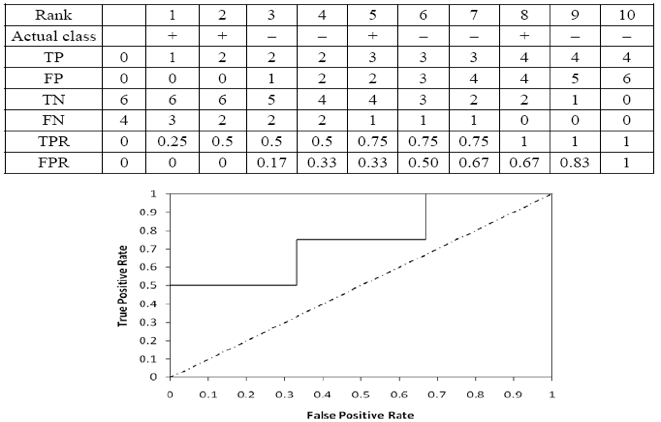
https://www.researchgate.net/deref/http%3A%2F%2Fwww.cs.uic.edu%2F~liub%2Fteach%2Fcs583-fall-06%2FCS583-supervised-learning.ppt

## ROC曲線を手で書くには？

### メインアイデア
"ROC曲線の記事"でやられていることを離散的に行う。つまり、二値判別の確率において、閾値を1から0まで変化させて、TPRとFPRを書いていくということになります。何を言っているかわからないと思うので、以下に具体例をしめします。

### 具体例
ロジスティック回帰なり使って、二値判別した結果、こんなデータが得られたとしましょう。

In [ ]:
##import
from IPython.core.display import display
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score

In [ ]:
df = pd.DataFrame({
    'prob': [0.98, 0.9, 0.8, 0.7, 0.3, 0.2, 0.1],
    'actual_label': [1, 1, 1, 1, 0, 0, 0],
})
df = df[['prob', 'actual_label']]
df

probはlabelが1である確率を示しています。actual_labelを見ると理想的なまでに綺麗に分離できています。ここでprobを使って予測をしたいと思います。多くの人はprob>0.5で1のラベルをつければいいと判断するでしょう。ちょっとやってみます。

In [ ]:
df['pred_label'] = (df.prob > 0.5).astype(int)
df

当たり前ですが綺麗に正解のlabelをつけることができました。

In [ ]:
tn, fp, fn, tp = confusion_matrix(df.actual_label, df.pred_label, ).ravel()
##tnから返すっていうトラップすぎる順番で泣いたおまえおまえおまえ
cnf_matrix = pd.DataFrame([
    [tp, fn],
    [fp, tn]
])
cnf_matrix.columns = ['PredictedAs1', 'PredictedAs0']
cnf_matrix.index = ['RealIs1', 'RealIs0']
display(cnf_matrix)
print('TPR=',tp/(tp+fn),'\tFPR=',fp/(fp+tn))

Confusion Matrixもこんな感じとなっています。ROC曲線を書くためのTPRもFPRも計算しておきました。
では"ROC曲線の記事"のように閾値を変えることをやってみます。まずはprob>0.99で1と予測するとしたとき。

In [ ]:
df['pred_label'] = (df.prob > 0.99).astype(int)
display(df)
tn, fp, fn, tp = confusion_matrix(df.actual_label, df.pred_label, ).ravel()
cnf_matrix = pd.DataFrame([
    [tp, fn],
    [fp, tn]
])
cnf_matrix.columns = ['PredictedAs1', 'PredictedAs0']
cnf_matrix.index = ['RealIs1', 'RealIs0']
display(cnf_matrix)
print('TPR=',tp/(tp+fn),'\tFPR=',fp/(fp+tn))

これもあたりまえですが1と判断する行がなくなりました。結果としてTPがなくなりFNが4つになりました。次に同じようにprob>0.95で1と予測するとしたとき。

In [ ]:
df['pred_label'] = (df.prob > 0.95).astype(int)
display(df)
tn, fp, fn, tp = confusion_matrix(df.actual_label, df.pred_label, ).ravel()
cnf_matrix = pd.DataFrame([
    [tp, fn],
    [fp, tn]
])
cnf_matrix.columns = ['PredictedAs1', 'PredictedAs0']
cnf_matrix.index = ['RealIs1', 'RealIs0']
display(cnf_matrix)
print('TPR=',tp/(tp+fn),'\tFPR=',fp/(fp+tn))

TPが一個増えFNが一つ減りましたね。このように閾値を変化させることでTPとFNのバランスが変化していきます。その結果TPRも変化します。このことはFPRにおいても同じことが言えます。次に閾値をどんどん変化させていったときのTPRとFPRの変化を見ていきましょう。

In [ ]:
for i in [0.01*x for x in range(100, 0 , -5)]:
    df['pred_label'] = (df.prob > i).astype(int)
    tn, fp, fn, tp = confusion_matrix(df.actual_label, df.pred_label, ).ravel()
    print('Threshold=',f"{i:.2f}",'\tTPR=',f"{tp/(tp+fn):.2f}",'\tFPR=',f"{fp/(fp+tn):.2f}")

閾値(Threshold)を媒介変数としたTPRとFPRの軌跡(トラジェクトリ)がROC曲線なのです。実際に描いて見るとこんな感じです。~~お気づきだと思いますがThresholdをデータのprobに合わせて動かせば、行数分だけの操作で曲線を描くのに必要なTPRとFPRが充分求まります。~~

In [ ]:
##visualization
from bokeh.plotting import figure
from bokeh.io import output_notebook, show
output_notebook()

In [ ]:
fpr, tpr, thresholds = roc_curve(df.actual_label, df.prob, pos_label=1)

##make figure
p = figure(
    title = "理想的なROC曲線", 
    plot_width=400, plot_height=400,
    x_range=(-0.01,1), y_range=(0,1.02)
)
##add line
p.line(
    fpr,
    tpr,
)
p.xaxis.axis_label = 'FPR'
p.yaxis.axis_label = 'TPR'

show(p)
print('AUCスコア:',roc_auc_score(df.actual_label, df.prob))

今回の仮定した予測なら綺麗に1と0を分離できるので、ご存知の通りの綺麗なROC曲線が書けます。AUC(エリアアンダーザカーブ)の面積も1となっています。

### 別の具体例1
AUCがモデルの性能を測る指標になるのを示すために、別の例を示します。先程と違って
* probが0.7であるにもかかわらずactual_labelが0
* probが0.3であるにもかかわらずactual_labelが1

というデータがあります。これは構築したモデルの性能がいまいちだったためにうまく判別できないデータが現れたと思ってください。

In [ ]:
df = pd.DataFrame({
    'prob': [0.98, 0.9, 0.8, 0.7, 0.3, 0.2, 0.1],
    'actual_label': [1, 1, 1, 0, 1, 0, 0],
})
df = df[['prob', 'actual_label']]
df

これを使ってROCとAUCを示します。

In [ ]:
fpr, tpr, thresholds = roc_curve(df.actual_label, df.prob, pos_label=1)

##make figure
p = figure(
    title = "性能がちょっと悪いモデルのROC曲線", 
    plot_width=400, plot_height=400,
    x_range=(-0.01,1), y_range=(0,1.02)
)
##add line
p.line(
    fpr,
    tpr,   
)
p.xaxis.axis_label = 'FPR'
p.yaxis.axis_label = 'TPR'

show(p)
print('AUCスコア:',roc_auc_score(df.actual_label, df.prob))

このように左上が凹んだ形になりました。またAUCも減りました。

### 別の具体例2
さらに別の例を示します。こんどはprobにかかわらずactual_labelには0,1,0,1...と並べました。つまりモデル化した判別は全くのデタラメである状況です。

In [ ]:
df = pd.DataFrame({
    'prob': [0.98, 0.9, 0.8, 0.7, 0.3, 0.2, 0.1],
    'actual_label': [0, 1, 0, 1, 0, 1, 0],
})
df = df[['prob', 'actual_label']]
df

これを使ってROCとAUCを示します。

In [ ]:
fpr, tpr, thresholds = roc_curve(df.actual_label, df.prob, pos_label=1)

##make figure
p = figure(
    title = "極めて悪いモデルのROC曲線", 
    plot_width=400, plot_height=400,
    x_range=(-0.01,1), y_range=(0,1.02)
)
##add line
p.line(
    fpr,
    tpr,   
)
p.xaxis.axis_label = 'FPR'
p.yaxis.axis_label = 'TPR'

show(p)
print('AUCスコア:',roc_auc_score(df.actual_label, df.prob))

上図のような形のため、AUCが0.5まで減りました。モデルが悪いとAUCが0.5に近づいていくのがわかると思います。

### 注意すべき例


一番はじめの具体例を少し書き換えて
* probが0.7であるにもかかわらずactual_labelが0

というデータがあるものをつくりました。

In [ ]:
df = pd.DataFrame({
    'prob': [0.98, 0.9, 0.8, 0.7, 0.3, 0.2, 0.1],
    'actual_label': [1, 1, 1, 0, 0, 0, 0],
})
df = df[['prob', 'actual_label']]
df

このときAUCは1となります。ほんとは0なのに1である確率を0.7も出してるなんてなんとなく悪そうと思う方がいるかも知れませんが、これは問題ないのです。閾値を0.75に設定すれば、きれいに分離できるからです。これが本当に問題ないかはここでは議論しませんが少なくともROC曲線ではわかりません。実際に描いてみると以下になります。

In [ ]:
fpr, tpr, thresholds = roc_curve(df.actual_label, df.prob, pos_label=1)

##make figure
p = figure(
    title = "理想的なROC曲線", 
    plot_width=400, plot_height=400,
    x_range=(-0.01,1), y_range=(0,1.02)
)
##add line
p.line(
    fpr,
    tpr,   
)
p.xaxis.axis_label = 'FPR'
p.yaxis.axis_label = 'TPR'

show(p)
print('AUCスコア:',roc_auc_score(df.actual_label, df.prob))

## まとめ
* ROC曲線が実際にどう書かれるのかstep by stepで確認しました。
* モデルが悪くなった場合にAUCの減少を確かめました。
* 勘違いを防ぐために注意すべき具体例を示しました。

~~まとめがまとめになってない！！文章を書くのって難しいですね~~

次回は、今回のROC曲線に関連してPR曲線をまとめたいと思います。